In [3]:
import pandas as pd
import numpy as np
import simpy
import random
from matplotlib import pyplot as plt
import seaborn as sns


### Processo Normal - Máquinas trabalham 24h/dia total 43.200 min

In [4]:
""" 10 - Máquinas trabalham 24h/dia - 7 dias na semana (43.200 min/semana)
        Tempo de produção para cada peça é de med= 10 min e dp = 2min
        O fabricante avisou que a probabilidade da máquina quebrar é 1 a cada 800 minutos trabalhados
        Apenas um técnico de manutenção por turno - Salário = R$3000,00 (*Durante as 24h sempre terá um técnico disponível)
        Custo do material de manutenção é aleatório de R$100 a R$600 reais
        Tempo para realizar a manutenção é aleatório de 20 a 40 min
        O técnico só pode realizar uma manutenção por vez, caso duas ou mais máquinas estejam quebradas no mesmo momento, uma delas terá que esperar
        até o técnico terminar o conserto da primeira
        A receita de cada peça fabricada é de R$17,50
        O lucro = receita das peças - salário do técnico - custo do material de manutenção
    """
ma=[]
pp=[]
fa=[]
tt=[]
tp=[]
cm=[]
pec=[]
ig=[]
luc=[]
for i in range(1000):#1000 SIMULAÇÕES
    try:
        #Variáveis
        pecas = 0
        falhas = 0
        custo_manut = 0
        receita = 0
        trab= 0
        parada = 0




        PROD_MED = 10.0         # Média do processo em minutos
        PROD_DP = 2.0         # Desvio padrão do processo
        MTTF = 800.0           # Media de tempo entre falhas
        LAMBDA = 1/MTTF          # Desvio padrão falhas
        TEMPO_MANUT = random.randint(20,40)     # Tempo de repara em minutos
        DUR_T = 30.0    # Duração de outros trabalhos em minutos
        NUM_MAQ = 10      # Numero de máquinas
        SEMANAS = 4              # Tempo de simulação em minutos
        SIM_TEMP = SEMANAS * 7 * 24 * 60  # Sim em min



        def time_per_part():
            """Tempo de fabricação por peça"""
            return random.normalvariate(PROD_MED,PROD_DP) # Distribuição normal


        def time_to_failure():
            """ Tempo de falha da máquina."""
            return random.expovariate(LAMBDA) # Distrbuição exponencial


        class Machine(object):
            """A máquina que produz as peças, quebra de vez em quando.
            Caso quebre o técnico é chamado

            """
            def __init__(self, env, name, repairman):
                self.env = env
                self.name = name
                self.parts_made = 0
                self.falhas =0
                self.trab = 0
                self.parada = 0
                self.broken = False

                # Máquina trabalhando e máquina parada por defeito.
                self.process = env.process(self.working(repairman))
                env.process(self.break_machine())

            def working(self, repairman):
                """
                Ao fazer uma peça, a máquina pode quebrar várias vezes.
                Solicite um técnico quando isso acontecer.

                """
                while True:
                    # Fazendo uma nova peça
                    done_in = time_per_part()
                    while done_in:
                        try:
                            # Trabalhando na peça
                            start = self.env.now
                            yield self.env.timeout(done_in)
                            self.trab += env.now - start
                            done_in = 0  # Quando 0, para o loop.
                            

                        except simpy.Interrupt:
                            self.broken = True
                            done_in -= self.env.now - start  # Quanto tempo resta?

                            # Solicita um técnico, apenas 1".
                            with repairman.request(priority=1) as req:
                                yield req
                                yield self.env.timeout(TEMPO_MANUT)

                            self.broken = False

                    # Peça está pronta!
                    self.parts_made += 1

            def break_machine(self):
                """Quebre a máquina"""
                while True:
                    falhas =+ 1
                    start = self.env.now
                    yield self.env.timeout(time_to_failure())
                    self.parada += env.now - start
                    if not self.broken:
                        # Apenas quebrar máquina se ela estiver funcionando.
                        self.process.interrupt()
                        self.falhas += 1



        def other_jobs(env, repairman):
            """Técnico volta para seu trabalho, prioridade menor"""
            while True:
                # Começa seu trabalho
                done_in = DUR_T
                while done_in:
                    # Repete o trabalho até terminar
                    # A prioridade desse trabalho é menor que a manutenção das máquinas.
                    with repairman.request(priority=2) as req:
                        yield req
                        try:
                            start = env.now
                            yield env.timeout(done_in)
                            done_in = 0
                        except simpy.Interrupt:
                            done_in -= env.now - start


        # Começar simulação
        print('Produção de uma fábrica')
        random.seed()  

        # Cria o ambiente e começa o processo de configuração
        env = simpy.Environment()
        repairman = simpy.PreemptiveResource(env, capacity=1) # 1 Técnico
        machines = [Machine(env, 'Máquina %d' % i, repairman)
                    for i in range(NUM_MAQ)]
        env.process(other_jobs(env, repairman))

        # Começa a simulação
        env.run(until=SIM_TEMP)

        # Análise de resultados
        print('Produção das máquinas após %s semanas (1 - Técnico, Sem manutenção preventiva):\n' % SEMANAS)
        for machine in machines:
            print('%s produziu %d peças.' % (machine.name, machine.parts_made))
            print('  %s parou %d vezes.' % (machine.name, machine.falhas))
            print('    %s trabalhou por %d minutos.' % (machine.name, machine.trab))
            print('       %s ficou parada por %d minutos.' % (machine.name,43200 - machine.trab))
            ma.append(machine.name)
            pp.append(machine.parts_made)
            fa.append(machine.falhas)
            tt.append(machine.trab)
            tp.append(43200 - machine.trab)
            cm.append(machine.falhas * random.randint(100,600))
            pecas+=machine.parts_made
            falhas+=machine.falhas
            custo_manut+= (machine.falhas * random.randint(100,600)) #O valor da manutenção varia de 100 a 600 reais (aleatóriamente)
            receita +=machine.parts_made * 17.5
            salario_tec = 3000 
            trab+=machine.trab
            parada+=machine.parada

        irog = (trab/432000)*100    
        lucro = receita - custo_manut - salario_tec
        print('\nTotal de peças produzidas em 1 mês: %s'% pecas)
        print('Total de pardas de manutenção em 1 mês: %s'% falhas)
        print('Custo de material para manutenção em 1 mês: R$%s'%custo_manut)
        print('A receita total das peças produzidas: R$%s'%receita)
        print('Salário do técnico: R$%s'%salario_tec)
        print('Lucro: R$%s'%lucro)
        print('Tempo total de máquina produzindo %i min' %trab)
        print('Tempo total de máquina parada %i min'%(432000 - trab))
        print('IROG = %.2f' %irog)

        luc.append(lucro)
        pec.append(pecas)
        ig.append(irog)
    except:
        luc.append('erro')
        pec.append('erro')
        ig.append('erro')

Produção de uma fábrica
Produção das máquinas após 4 semanas (1 - Técnico, Sem manutenção preventiva):

Máquina 0 produziu 3850 peças.
  Máquina 0 parou 46 vezes.
    Máquina 0 trabalhou por 38424 minutos.
       Máquina 0 ficou parada por 4775 minutos.
Máquina 1 produziu 3894 peças.
  Máquina 1 parou 37 vezes.
    Máquina 1 trabalhou por 38662 minutos.
       Máquina 1 ficou parada por 4537 minutos.
Máquina 2 produziu 3802 peças.
  Máquina 2 parou 51 vezes.
    Máquina 2 trabalhou por 37799 minutos.
       Máquina 2 ficou parada por 5400 minutos.
Máquina 3 produziu 3834 peças.
  Máquina 3 parou 52 vezes.
    Máquina 3 trabalhou por 38028 minutos.
       Máquina 3 ficou parada por 5171 minutos.
Máquina 4 produziu 3912 peças.
  Máquina 4 parou 33 vezes.
    Máquina 4 trabalhou por 38916 minutos.
       Máquina 4 ficou parada por 4283 minutos.
Máquina 5 produziu 3877 peças.
  Máquina 5 parou 36 vezes.
    Máquina 5 trabalhou por 38648 minutos.
       Máquina 5 ficou parada por 4551 minut

In [6]:
list1 = list(zip(ma,pp, fa,tt,tp,cm))
df_maq = pd.DataFrame(list1,columns=['Máquina','Peças','Falhas na máquina','Tempo trabalhando (min)','Tempo parada','Custo de material para manutenção'])
df_maq.to_excel('Original máquinas.xlsx', index=False)

In [257]:
df_original = pd.DataFrame(pec, columns=['Peças produzidas'])
df_original['Lucro'] = luc
df_original['IROG'] = ig
df_original.Lucro[df_original.Lucro == 'erro'] = '500000'
df_original.IROG[df_original.IROG == 'erro'] = '87'
df_original['Peças produzidas'][df_original['Peças produzidas'] == 'erro'] = '38000'
df_original = df_original.astype(float)
df_original.describe().to_excel('Análise Resultado série original.xlsx')
df_original.to_excel('Reultado série original.xlsx')

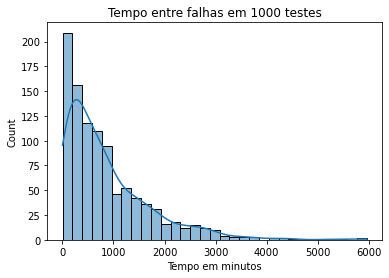

In [263]:
x = [random.expovariate(LAMBDA) for r in range(1000)]                   
sns.histplot(x, kde=True)
plt.title('Tempo entre falhas em 1000 testes')
plt.xlabel('Tempo em minutos')
plt.savefig('Tempo entre falhas em 1000 testes.png', format='png')
plt.show()

In [276]:
x = [random.expovariate(LAMBDA) for r in range(1000)]
df_temp_manu = pd.DataFrame(x,columns = ['Momento em que a máquina quebra'])
df_temp_manu.to_excel('MTTF.xlsx')

In [277]:
df_temp_manu[df_temp_manu['Momento em que a máquina quebra']<200]

,Momento em que a máquina quebra
1,124.335327
3,121.808993
4,122.781124
5,192.991839
9,183.483985
...,...
970,9.176464
985,160.913615
989,77.596860
990,139.265097


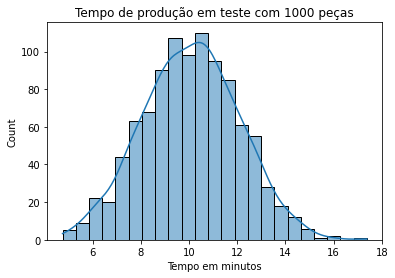

In [269]:
x = [random.normalvariate(PROD_MED, PROD_DP) for r in range(1000)]                   
sns.histplot(x, kde=True)
plt.title('Tempo de produção em teste com 1000 peças')
plt.xlabel('Tempo em minutos')
plt.savefig('Tempo de produção em teste com 1000 peças.png', format='png')
plt.show()


In [268]:
x = [random.normalvariate(PROD_MED, PROD_DP) for r in range(1000)]
df_tp = pd.DataFrame(x,columns = ['Momento em que a peça é produzida'])
df_tp.to_excel('Tempo prod peça.xlsx')

## Opção 1 - Com manutenção preventiva

In [7]:
""" 10 - Máquinas trabalham 24h/dia - 7 dias na semana (43.200 min/dia)
    Tempo de produção para cada peça é de med= 10 min e dp = 2min
    Por recomendação do fabricante, será realizada a manutenção preventiva a cada 200 min com dp = 10 min 
    Apenas um técnico de manutenção por turno - Salário total = R$3000,00
    Custo do material de manutenção preventiva é menor e  é aleatório de R$100 a R$200 reais
    Tempo para realizar a manutenção é menor e é aleatório de 10 a 15 min
    O técnico só pode realizar uma manutenção por vez, caso duas ou mais máquinas estejam quebradas no mesmo momento, uma delas terá que esperar
      até o técnico terminar o conserto da primeira
    A receita de cada peça fabricada é de R$17,50
    O lucro = receita das peças - salário do técnico - custo do material de manutenção
    """
pec=[]
ma=[]
pp=[]
fa=[]
tt=[]
tp=[]
cm=[]
ig=[]
luc=[]
for i in range(1):
    try:
        #Variáveis
        pecas = 0
        falhas = 0
        custo_manut = 0
        receita = 0
        trab= 0
        parada = 0




        PROD_MED = 10.0         # Média do processo em minutos
        PROD_DP = 2.0         # Desvio padrão do processo
        MTTF_MED = 200.0           # Media de tempo entre as manutenções preventivas
        MTTF_DP = 10.0         # Desvio padrão falhas
        TEMPO_MANUT = random.randint(10,15)     # Tempo de repara em minutos
        DUR_T = 30.0    # Duração de outros trabalhos em minutos
        NUM_MAQ = 10      # Numero de máquinas
        SEMANAS = 4              # Tempo de simulação em minutos
        SIM_TEMP = SEMANAS * 7 * 24 * 60  # Sim em min



        def time_per_part():
            """Tempo de fabricação por peça"""
            return random.normalvariate(PROD_MED, PROD_DP) # Distribuição normal


        def time_to_failure():
            """ Tempo de falha da máquina."""
            return random.normalvariate(MTTF_MED, MTTF_DP) # Distrbuição exponencial - quanto mais tempo ela trabalha, maior a chance de defeito


        class Machine(object):
            """A máquina que produz as peças, quebra de vez em quando.
            Caso quebre o técnico é chamado

            """
            def __init__(self, env, name, repairman):
                self.env = env
                self.name = name
                self.parts_made = 0
                self.falhas =0
                self.trab = 0
                self.parada = 0
                self.broken = False

                # Máquina trabalhando e máquina parada por defeito.
                self.process = env.process(self.working(repairman))
                env.process(self.break_machine())

            def working(self, repairman):
                """
                Ao fazer uma peça, a máquina pode quebrar várias vezes.
                Solicite um técnico quando isso acontecer.

                """
                while True:
                    # Fazendo uma nova peça
                    done_in = time_per_part()
                    while done_in:
                        try:
                            # Trabalhando na peça
                            start = self.env.now
                            yield self.env.timeout(done_in)
                            self.trab += env.now - start
                            done_in = 0  # Quando 0, para o loop.
                            

                        except simpy.Interrupt:
                            self.broken = True
                            done_in -= self.env.now - start  # Quanto tempo resta?

                            # Solicita um técnico, apenas 1".
                            with repairman.request(priority=1) as req:
                                yield req
                                yield self.env.timeout(TEMPO_MANUT)

                            self.broken = False

                    # Peça está pronta!
                    self.parts_made += 1

            def break_machine(self):
                """Quebre a máquina"""
                while True:
                    falhas =+ 1
                    start = self.env.now
                    yield self.env.timeout(time_to_failure())
                    self.parada += env.now - start
                    if not self.broken:
                        # Apenas quebrar máquina se ela estiver funcionando.
                        self.process.interrupt()
                        self.falhas += 1



        def other_jobs(env, repairman):
            """Técnico volta para seu trabalho, prioridade menor"""
            while True:
                # Começa seu trabalho
                done_in = DUR_T
                while done_in:
                    # Repete o trabalho até terminar
                    # A prioridade desse trabalho é menor que a manutenção das máquinas.
                    with repairman.request(priority=2) as req:
                        yield req
                        try:
                            start = env.now
                            yield env.timeout(done_in)
                            done_in = 0
                        except simpy.Interrupt:
                            done_in -= env.now - start


        # Começar simulação
        print('Produção de uma fábrica')
        random.seed()  

        # Cria o ambiente e começa o processo de configuração
        env = simpy.Environment()
        repairman = simpy.PreemptiveResource(env, capacity=1) # 1 Técnico
        machines = [Machine(env, 'Máquina %d' % i, repairman)
                    for i in range(NUM_MAQ)]
        env.process(other_jobs(env, repairman))

        # Começa a simulação
        env.run(until=SIM_TEMP)

        # Análise de resultados
        print('Produção das máquinas após %s semanas (1 - Técnico, Sem manutenção preventiva):\n' % SEMANAS)
        for machine in machines:
            print('%s produziu %d peças.' % (machine.name, machine.parts_made))
            print('  %s parou %d vezes.' % (machine.name, machine.falhas))
            print('    %s trabalhou por %d minutos.' % (machine.name, machine.trab))
            print('       %s ficou parada por %d minutos.' % (machine.name,43200 - machine.trab))
            ma.append(machine.name)
            pp.append(machine.parts_made)
            fa.append(machine.falhas)
            tt.append(machine.trab)
            tp.append(43200 - machine.trab)
            cm.append(machine.falhas * random.randint(100,600))
            pecas+=machine.parts_made
            falhas+=machine.falhas
            custo_manut+= (machine.falhas * random.randint(100,200)) #O valor da manutenção varia de 100 a 200 reais (aleatóriamente)
            receita +=machine.parts_made * 17.5
            salario_tec = 3000 
            trab+=machine.trab
            parada+=machine.parada

        irog = (trab/432000)*100        
        lucro = receita - custo_manut - salario_tec
        print('\nTotal de peças produzidas em 1 mês: %s'% pecas)
        print('Total de pardas de manutenção em 1 mês: %s'% falhas)
        print('Custo de material para manutenção em 1 mês: R$%s'%custo_manut)
        print('A receita total das peças produzidas: R$%s'%receita)
        print('Salário do técnico: R$%s'%salario_tec)
        print('Lucro: R$%s'%lucro)
        print('Tempo total de máquina produzindo %i min' %trab)
        print('Tempo total de máquina parada %i min'%(432000 - trab))
        print('IROG = %.2f' %irog)

        luc.append(lucro)
        pec.append(pecas)
        ig.append(irog)
    except:
        luc.append('erro')
        pec.append('erro')
        ig.append('erro')

Produção de uma fábrica
Produção das máquinas após 4 semanas (1 - Técnico, Sem manutenção preventiva):

Máquina 0 produziu 3641 peças.
  Máquina 0 parou 201 vezes.
    Máquina 0 trabalhou por 35088 minutos.
       Máquina 0 ficou parada por 8111 minutos.
Máquina 1 produziu 3590 peças.
  Máquina 1 parou 201 vezes.
    Máquina 1 trabalhou por 34718 minutos.
       Máquina 1 ficou parada por 8481 minutos.
Máquina 2 produziu 3622 peças.
  Máquina 2 parou 201 vezes.
    Máquina 2 trabalhou por 35175 minutos.
       Máquina 2 ficou parada por 8024 minutos.
Máquina 3 produziu 3557 peças.
  Máquina 3 parou 201 vezes.
    Máquina 3 trabalhou por 34479 minutos.
       Máquina 3 ficou parada por 8720 minutos.
Máquina 4 produziu 3640 peças.
  Máquina 4 parou 200 vezes.
    Máquina 4 trabalhou por 35350 minutos.
       Máquina 4 ficou parada por 7849 minutos.
Máquina 5 produziu 3582 peças.
  Máquina 5 parou 203 vezes.
    Máquina 5 trabalhou por 34742 minutos.
       Máquina 5 ficou parada por 8457

In [8]:
list1 = list(zip(ma,pp, fa,tt,tp,cm))
df_maq = pd.DataFrame(list1,columns=['Máquina','Peças','Falhas na máquina','Tempo trabalhando (min)','Tempo parada','Custo de material para manutenção'])
df_maq.to_excel('Op1 máquinas.xlsx', index=False)

In [279]:
df_o1 = pd.DataFrame(pec, columns=['Peças produzidas'])
df_o1['Lucro'] = luc
df_o1['IROG'] = ig
df_o1.Lucro[df_o1.Lucro == 'erro'] = '500000'
df_o1.IROG[df_o1.IROG == 'erro'] = '87'
df_o1['Peças produzidas'][df_o1['Peças produzidas'] == 'erro'] = '38000'
df_o1 = df_o1.astype(float)
df_o1.describe().to_excel('Análise Resultado Primeira opção.xlsx')
df_o1.to_excel('Reultado primeira opção.xlsx')

## 2 Opção - Manutenção preventiva e contratar mais um Técnico por turno

In [9]:
""" 10 - Máquinas trabalham 24h/dia - 7 dias na semana (43.200 min/semana)
        Tempo de produção para cada peça é de med= 10 min e dp = 2min
        O fabricante avisou que a probabilidade da máquina quebrar é 1 a cada 800 minutos trabalhados
        Dois técnicos de manutenção por turno - Salário = R$3000,00 (*Durante as 24h sempre terá dois técnicos disponíveis)
        Custo do material de manutenção é aleatório de R$100 a R$600 reais
        Tempo para realizar a manutenção é aleatório de 20 a 40 min
        O técnico só pode realizar uma manutenção por vez, caso duas ou mais máquinas estejam quebradas no mesmo momento, uma delas terá que esperar
        até o técnico terminar o conserto da primeira
        A receita de cada peça fabricada é de R$17,50
        O lucro = receita das peças - salário do técnico - custo do material de manutenção
    """
pec=[]
ma=[]
pp=[]
fa=[]
tt=[]
tp=[]
cm=[]
ig=[]
luc=[]
for i in range(1):#Número de simulações
    try:
        #Variáveis
        pecas = 0
        falhas = 0
        custo_manut = 0
        receita = 0
        trab= 0
        parada = 0




        PROD_MED = 10.0         # Média do processo em minutos
        PROD_DP = 2.0         # Desvio padrão do processo
        MTTF = 800.0           # Media de tempo entre falhas
        LAMBDA = 1/MTTF          # Desvio padrão falhas
        TEMPO_MANUT = random.randint(20,40)     # Tempo de repara em minutos
        DUR_T = 30.0    # Duração de outros trabalhos em minutos
        NUM_MAQ = 10      # Numero de máquinas
        SEMANAS = 4              # Tempo de simulação em minutos
        SIM_TEMP = SEMANAS * 7 * 24 * 60  # Sim em min



        def time_per_part():
            """Tempo de fabricação por peça"""
            return random.normalvariate(PROD_MED,PROD_DP) # Distribuição normal


        def time_to_failure():
            """ Tempo de falha da máquina."""
            return random.expovariate(LAMBDA) # Distrbuição exponencial


        class Machine(object):
            """A máquina que produz as peças, quebra de vez em quando.
            Caso quebre o técnico é chamado

            """
            def __init__(self, env, name, repairman):
                self.env = env
                self.name = name
                self.parts_made = 0
                self.falhas =0
                self.trab = 0
                self.parada = 0
                self.broken = False

                # Máquina trabalhando e máquina parada por defeito.
                self.process = env.process(self.working(repairman))
                env.process(self.break_machine())

            def working(self, repairman):
                """
                Ao fazer uma peça, a máquina pode quebrar várias vezes.
                Solicite um técnico quando isso acontecer.

                """
                while True:
                    # Fazendo uma nova peça
                    done_in = time_per_part()
                    while done_in:
                        try:
                            # Trabalhando na peça
                            start = self.env.now
                            yield self.env.timeout(done_in)
                            self.trab += env.now - start
                            done_in = 0  # Quando 0, para o loop.
                            

                        except simpy.Interrupt:
                            self.broken = True
                            done_in -= self.env.now - start  # Quanto tempo resta?

                            # Solicita um técnico, apenas 1".
                            with repairman.request(priority=1) as req:
                                yield req
                                yield self.env.timeout(TEMPO_MANUT)

                            self.broken = False

                    # Peça está pronta!
                    self.parts_made += 1

            def break_machine(self):
                """Quebre a máquina"""
                while True:
                    falhas =+ 1
                    start = self.env.now
                    yield self.env.timeout(time_to_failure())
                    self.parada += env.now - start
                    if not self.broken:
                        # Apenas quebrar máquina se ela estiver funcionando.
                        self.process.interrupt()
                        self.falhas += 1



        def other_jobs(env, repairman):
            """Técnico volta para seu trabalho, prioridade menor"""
            while True:
                # Começa seu trabalho
                done_in = DUR_T
                while done_in:
                    # Repete o trabalho até terminar
                    # A prioridade desse trabalho é menor que a manutenção das máquinas.
                    with repairman.request(priority=2) as req:
                        yield req
                        try:
                            start = env.now
                            yield env.timeout(done_in)
                            done_in = 0
                        except simpy.Interrupt:
                            done_in -= env.now - start


        # Começar simulação
        print('Produção de uma fábrica')
        random.seed()  

        # Cria o ambiente e começa o processo de configuração
        env = simpy.Environment()
        repairman = simpy.PreemptiveResource(env, capacity=2) # 1 Técnico
        machines = [Machine(env, 'Máquina %d' % i, repairman)
                    for i in range(NUM_MAQ)]
        env.process(other_jobs(env, repairman))

        # Começa a simulação
        env.run(until=SIM_TEMP)

        # Análise de resultados
        print('Produção das máquinas após %s semanas (1 - Técnico, Sem manutenção preventiva):\n' % SEMANAS)
        for machine in machines:
            print('%s produziu %d peças.' % (machine.name, machine.parts_made))
            print('  %s parou %d vezes.' % (machine.name, machine.falhas))
            print('    %s trabalhou por %d minutos.' % (machine.name, machine.trab))
            print('       %s ficou parada por %d minutos.' % (machine.name,43200 - machine.trab))
            ma.append(machine.name)
            pp.append(machine.parts_made)
            fa.append(machine.falhas)
            tt.append(machine.trab)
            tp.append(43200 - machine.trab)
            cm.append(machine.falhas * random.randint(100,600))
            pecas+=machine.parts_made
            falhas+=machine.falhas
            custo_manut+= (machine.falhas * random.randint(100,600)) #O valor da manutenção varia de 100 a 600 reais (aleatóriamente)
            receita +=machine.parts_made * 17.5
            salario_tec = 6000 
            trab+=machine.trab
            parada+=machine.parada

        irog = (trab/432000)*100    
        lucro = receita - custo_manut - salario_tec
        print('\nTotal de peças produzidas em 1 mês: %s'% pecas)
        print('Total de pardas de manutenção em 1 mês: %s'% falhas)
        print('Custo de material para manutenção em 1 mês: R$%s'%custo_manut)
        print('A receita total das peças produzidas: R$%s'%receita)
        print('Salário do técnico: R$%s'%salario_tec)
        print('Lucro: R$%s'%lucro)
        print('Tempo total de máquina produzindo %i min' %trab)
        print('Tempo total de máquina parada %i min'%(432000 - trab))
        print('IROG = %.2f' %irog)

        luc.append(lucro)
        pec.append(pecas)
        ig.append(irog)
    except:
        luc.append('erro')
        pec.append('erro')
        ig.append('erro')

Produção de uma fábrica
Produção das máquinas após 4 semanas (1 - Técnico, Sem manutenção preventiva):

Máquina 0 produziu 3796 peças.
  Máquina 0 parou 62 vezes.
    Máquina 0 trabalhou por 37693 minutos.
       Máquina 0 ficou parada por 5506 minutos.
Máquina 1 produziu 3890 peças.
  Máquina 1 parou 36 vezes.
    Máquina 1 trabalhou por 38756 minutos.
       Máquina 1 ficou parada por 4443 minutos.
Máquina 2 produziu 3863 peças.
  Máquina 2 parou 45 vezes.
    Máquina 2 trabalhou por 38443 minutos.
       Máquina 2 ficou parada por 4756 minutos.
Máquina 3 produziu 3881 peças.
  Máquina 3 parou 40 vezes.
    Máquina 3 trabalhou por 38596 minutos.
       Máquina 3 ficou parada por 4603 minutos.
Máquina 4 produziu 3840 peças.
  Máquina 4 parou 47 vezes.
    Máquina 4 trabalhou por 38234 minutos.
       Máquina 4 ficou parada por 4965 minutos.
Máquina 5 produziu 3836 peças.
  Máquina 5 parou 47 vezes.
    Máquina 5 trabalhou por 38260 minutos.
       Máquina 5 ficou parada por 4939 minut

In [10]:
list1 = list(zip(ma,pp, fa,tt,tp,cm))
df_maq = pd.DataFrame(list1,columns=['Máquina','Peças','Falhas na máquina','Tempo trabalhando (min)','Tempo parada','Custo de material para manutenção'])
df_maq.to_excel('Op2 máquinas.xlsx', index=False)

In [286]:
df_o2 = pd.DataFrame(pec, columns=['Peças produzidas'])
df_o2['Lucro'] = luc
df_o2['IROG'] = ig
df_o2.Lucro[df_o2.Lucro == 'erro'] = '500000'
df_o2.IROG[df_o2.IROG == 'erro'] = '87'
df_o2['Peças produzidas'][df_o2['Peças produzidas'] == 'erro'] = '38000'
df_o2 = df_o2.astype(float)
df_o2.describe().to_excel('Análise Resultado Segunda.xlsx')
df_o2.to_excel('Reultado segunda opção.xlsx')

## Opção 3 - Comprar mais uma máquina

In [11]:
""" 11 - Máquinas trabalham 24h/dia - 7 dias na semana (43.200 min/semana)
        Tempo de produção para cada peça é de med= 10 min e dp = 2min
        O fabricante avisou que a probabilidade da máquina quebrar é 1 a cada 800 minutos trabalhados
        Apenas um técnico de manutenção por turno - Salário = R$3000,00 (*Durante as 24h sempre terá um técnico disponível)
        Custo do material de manutenção é aleatório de R$100 a R$600 reais
        Tempo para realizar a manutenção é aleatório de 20 a 40 min
        O técnico só pode realizar uma manutenção por vez, caso duas ou mais máquinas estejam quebradas no mesmo momento, uma delas terá que esperar
        até o técnico terminar o conserto da primeira
        A receita de cada peça fabricada é de R$17,50
        O lucro = receita das peças - salário do técnico - custo do material de manutenção
        Preço da máquina R$985.00,00
    """
pec=[]
ma=[]
pp=[]
fa=[]
tt=[]
tp=[]
cm=[]
ig=[]
luc=[]
for i in range(1):
    try:
        #Variáveis
        pecas = 0
        falhas = 0
        custo_manut = 0
        receita = 0
        trab= 0
        parada = 0




        PROD_MED = 10.0         # Média do processo em minutos
        PROD_DP = 2.0         # Desvio padrão do processo
        MTTF = 800.0           # Media de tempo entre falhas
        LAMBDA = 1/MTTF          # Desvio padrão falhas
        TEMPO_MANUT = random.randint(20,40)     # Tempo de repara em minutos
        DUR_T = 30.0    # Duração de outros trabalhos em minutos
        NUM_MAQ = 11      # Numero de máquinas
        SEMANAS = 4              # Tempo de simulação em minutos
        SIM_TEMP = SEMANAS * 7 * 24 * 60  # Sim em min



        def time_per_part():
            """Tempo de fabricação por peça"""
            return random.normalvariate(PROD_MED,PROD_DP) # Distribuição normal


        def time_to_failure():
            """ Tempo de falha da máquina."""
            return random.expovariate(LAMBDA) # Distrbuição exponencial


        class Machine(object):
            """A máquina que produz as peças, quebra de vez em quando.
            Caso quebre o técnico é chamado

            """
            def __init__(self, env, name, repairman):
                self.env = env
                self.name = name
                self.parts_made = 0
                self.falhas =0
                self.trab = 0
                self.parada = 0
                self.broken = False

                # Máquina trabalhando e máquina parada por defeito.
                self.process = env.process(self.working(repairman))
                env.process(self.break_machine())

            def working(self, repairman):
                """
                Ao fazer uma peça, a máquina pode quebrar várias vezes.
                Solicite um técnico quando isso acontecer.

                """
                while True:
                    # Fazendo uma nova peça
                    done_in = time_per_part()
                    while done_in:
                        try:
                            # Trabalhando na peça
                            start = self.env.now
                            yield self.env.timeout(done_in)
                            self.trab += env.now - start
                            done_in = 0  # Quando 0, para o loop.
                            

                        except simpy.Interrupt:
                            self.broken = True
                            done_in -= self.env.now - start  # Quanto tempo resta?

                            # Solicita um técnico, apenas 1".
                            with repairman.request(priority=1) as req:
                                yield req
                                yield self.env.timeout(TEMPO_MANUT)

                            self.broken = False

                    # Peça está pronta!
                    self.parts_made += 1

            def break_machine(self):
                """Quebre a máquina"""
                while True:
                    falhas =+ 1
                    start = self.env.now
                    yield self.env.timeout(time_to_failure())
                    self.parada += env.now - start
                    if not self.broken:
                        # Apenas quebrar máquina se ela estiver funcionando.
                        self.process.interrupt()
                        self.falhas += 1



        def other_jobs(env, repairman):
            """Técnico volta para seu trabalho, prioridade menor"""
            while True:
                # Começa seu trabalho
                done_in = DUR_T
                while done_in:
                    # Repete o trabalho até terminar
                    # A prioridade desse trabalho é menor que a manutenção das máquinas.
                    with repairman.request(priority=2) as req:
                        yield req
                        try:
                            start = env.now
                            yield env.timeout(done_in)
                            done_in = 0
                        except simpy.Interrupt:
                            done_in -= env.now - start


        # Começar simulação
        print('Produção de uma fábrica')
        random.seed()  

        # Cria o ambiente e começa o processo de configuração
        env = simpy.Environment()
        repairman = simpy.PreemptiveResource(env, capacity=1) # 1 Técnico
        machines = [Machine(env, 'Máquina %d' % i, repairman)
                    for i in range(NUM_MAQ)]
        env.process(other_jobs(env, repairman))

        # Começa a simulação
        env.run(until=SIM_TEMP)

        # Análise de resultados
        print('Produção das máquinas após %s semanas (1 - Técnico, Sem manutenção preventiva):\n' % SEMANAS)
        for machine in machines:
            print('%s produziu %d peças.' % (machine.name, machine.parts_made))
            print('  %s parou %d vezes.' % (machine.name, machine.falhas))
            print('    %s trabalhou por %d minutos.' % (machine.name, machine.trab))
            print('       %s ficou parada por %d minutos.' % (machine.name,43200 - machine.trab))
            ma.append(machine.name)
            pp.append(machine.parts_made)
            fa.append(machine.falhas)
            tt.append(machine.trab)
            tp.append(43200 - machine.trab)
            cm.append(machine.falhas * random.randint(100,600))
            pecas+=machine.parts_made
            falhas+=machine.falhas
            custo_manut+= (machine.falhas * random.randint(100,600)) #O valor da manutenção varia de 100 a 600 reais (aleatóriamente)
            receita +=machine.parts_made * 17.5
            salario_tec = 3000 
            trab+=machine.trab
            parada+=machine.parada

        irog = (trab/475200)*100    
        lucro = receita - custo_manut - salario_tec
        print('\nTotal de peças produzidas em 1 mês: %s'% pecas)
        print('Total de pardas de manutenção em 1 mês: %s'% falhas)
        print('Custo de material para manutenção em 1 mês: R$%s'%custo_manut)
        print('A receita total das peças produzidas: R$%s'%receita)
        print('Salário do técnico: R$%s'%salario_tec)
        print('Lucro: R$%s'%lucro)
        print('Tempo total de máquina produzindo %i min' %trab)
        print('Tempo total de máquina parada %i min'%(475200 - trab))
        print('IROG = %.2f' %irog)

        luc.append(lucro)
        pec.append(pecas)
        ig.append(irog)
    except:
        luc.append('erro')
        pec.append('erro')
        ig.append('erro')

Produção de uma fábrica
Produção das máquinas após 4 semanas (1 - Técnico, Sem manutenção preventiva):

Máquina 0 produziu 3870 peças.
  Máquina 0 parou 45 vezes.
    Máquina 0 trabalhou por 38292 minutos.
       Máquina 0 ficou parada por 4907 minutos.
Máquina 1 produziu 3842 peças.
  Máquina 1 parou 49 vezes.
    Máquina 1 trabalhou por 38355 minutos.
       Máquina 1 ficou parada por 4844 minutos.
Máquina 2 produziu 3832 peças.
  Máquina 2 parou 43 vezes.
    Máquina 2 trabalhou por 38384 minutos.
       Máquina 2 ficou parada por 4815 minutos.
Máquina 3 produziu 3846 peças.
  Máquina 3 parou 51 vezes.
    Máquina 3 trabalhou por 38173 minutos.
       Máquina 3 ficou parada por 5026 minutos.
Máquina 4 produziu 3865 peças.
  Máquina 4 parou 46 vezes.
    Máquina 4 trabalhou por 38309 minutos.
       Máquina 4 ficou parada por 4890 minutos.
Máquina 5 produziu 3806 peças.
  Máquina 5 parou 57 vezes.
    Máquina 5 trabalhou por 37931 minutos.
       Máquina 5 ficou parada por 5268 minut

In [12]:
list1 = list(zip(ma,pp, fa,tt,tp,cm))
df_maq = pd.DataFrame(list1,columns=['Máquina','Peças','Falhas na máquina','Tempo trabalhando (min)','Tempo parada','Custo de material para manutenção'])
df_maq.to_excel('Op3 máquinas.xlsx', index=False)

In [291]:
df_o3 = pd.DataFrame(pec, columns=['Peças produzidas'])
df_o3['Lucro'] = luc
df_o3['IROG'] = ig
df_o3.Lucro[df_o3.Lucro == 'erro'] = '500000'
df_o3.IROG[df_o3.IROG == 'erro'] = '87'
df_o3['Peças produzidas'][df_o3['Peças produzidas'] == 'erro'] = '38000'
df_o3 = df_o3.astype(float)
df_o3.describe().to_excel('Análise Resultado Terceira.xlsx')
df_o3.to_excel('Reultado terceira opção.xlsx')